# DETECCIÓN DE LENGUAJE EN TEXTO USANDO ELASTICSEARCH Y KIBANA

Este notebook tiene cómo objetivo, utilizar elasticsearch y kibana para realizar la detección del idioma en los textos contenidos en un archivo csv.

## Requisitos
Para ejecutar correctamente esta demo, se requiere:
- Elasticsearch y kibana ejecutandose localmente (localhost) por los puertos  9200 y 5601.
- Python 3.0 con Jupyter


In [2]:
#Generar diccionario con los lenguajes soportados por elastic
# https://www.elastic.co/guide/en/machine-learning/7.6/ml-lang-ident.html

languages_dic = {
    'af': 'Afrikaans', 'am': 'Amharic', 'ar': 'Arabic', 'az': 'Azerbaijani', 'be': 'Belarusian', 'bg': 'Bulgarian', 'bg-Latn': 'Bulgarian', 'bn': 'Bengali', 'bs': 'Bosnian','ca': 'Catalan',
    'ceb': 'Cebuano', 'co': 'Corsican', 'cs': 'Czech', 'cy': 'Welsh','da': 'Danish', 'de': 'German', 'el': 'Greek, modern', 'el-Latn': 'Greek, modern', 'en': 'English', 'eo': 'Esperanto',
    'es': 'Spanish, Castilian', 'et': 'Estonian','eu': 'Basque', 'fa': 'Persian', 'fi': 'Finnish', 'fil': 'Filipino', 'fr': 'French', 'fy': 'Western Frisian', 'ga': 'Irish', 'gd': 'Gaelic',
    'gl': 'Galician', 'gu': 'Gujarati', 'ha': 'Hausa', 'haw': 'Hawaiian', 'hi': 'Hindi', 'hi-Latn': 'Hindi', 'hmn': 'Hmong', 'hr': 'Croatian', 'ht': 'Haitian', 'hu': 'Hungarian',
    'hy': 'Armenian', 'id': 'Indonesian', 'ig': 'Igbo', 'is': 'Icelandic', 'it': 'Italian', 'iw': 'Hebrew', 'ja': 'Japanese', 'ja-Latn': 'Japanese', 'jv': 'Javanese', 'ka': 'Georgian',
    'kk': 'Kazakh', 'km': 'Central Khmer', 'kn': 'Kannada', 'ko': 'Korean', 'ku': 'Kurdish', 'ky': 'Kirghiz', 'la': 'Latin', 'lb': 'Luxembourgish', 'lo': 'Lao', 'lt': 'Lithuanian',
    'lv': 'Latvian', 'mg': 'Malagasy', 'mi': 'Maori', 'mk': 'Macedonian', 'ml': 'Malayalam', 'mn': 'Mongolian', 'mr': 'Marathi', 'ms': 'Malay', 'mt': 'Maltese', 'my': 'Burmese',
    'ne': 'Nepali', 'nl': 'Dutch, Flemish', 'no': 'Norwegian', 'ny': 'Chichewa', 'pa': 'Punjabi', 'pl': 'Polish', 'ps': 'Pashto',' pt': 'Portuguese', 'ro': 'Romanian', 'ru': 'Russian',
    'ru-Latn': 'Russian', 'sd': 'Sindhi', 'si': 'Sinhala', 'sk': 'Slovak', 'sl': 'Slovenian', 'sm': 'Samoan', 'sn': 'Shona', 'so': 'Somali', 'sq': 'Albanian', 'sr': 'Serbian',
    'st': 'Southern Sotho', 'su': 'Sundanese',  'sv': 'Swedish', 'sw': 'Swahili', 'ta': 'Tamil', 'te': 'Telugu', 'tg': 'Tajik', 'th': 'Thai','tr': 'Turkish', 'uk': 'Ukrainian',
    'ur': 'Urdu', 'uz': 'Uzbek', 'vi': 'Vietnamese', 'xh': 'Xhosa', 'yi': 'Yiddish', 'yo': 'Yoruba', 'zh': 'Chinese', 'zh-Latn': 'Chinese',     'zu': 'Zulu'
}


In [116]:
#funcion para enviar documento con el texto a detectar idioma al ingest pipeline de kibana
def post_localhost_kibana(text):
    import requests

    url = 'http://localhost:5601/api/ingest_pipelines/simulate'
    headers = {'Content-Type': 'application/json',
               'Refer': 'http://localhost:5601/app/management/ingest/ingest_pipelines/edit/Language_ident',
               'kbn-version': '7.16.3'}
    payload = {'somekey': text}

    response = requests.post(url, data = create_json_payload(text), headers = headers)
    
    return (((((response.json()["docs"])[0])["doc"]))["_source"])["_ml"]["lang_ident"]["predicted_value"]

In [117]:
#funcion para generar el request payload del ingest pipeline
def create_json_payload(text):
    import json
    data = {
        'documents':[
                  {
                     '_source':{
                    'contents':'{content}'.format(content = text)                        
                     }
                  }
               ],
               'pipeline':{
                  'processors':[
                     {
                        'inference':{
                           'model_id':'lang_ident_model_1',
                           'target_field':'_ml.lang_ident',
                           'field_map':{
                              'contents':'text'
                           },
                           'inference_config':{
                              'classification':{
                                 'num_top_classes':2
                              }
                           }
                        }
                     }
                  ]
               }
    }
  
    
    return json.dumps(data)

In [135]:
## Se lee el dataset y se genera un nuevo archivo con una columna andicional, con el resultado de la deteccion
## realizada por elastic search language detection.
import csv
from csv import reader
i = 1

##Archivo para almacenar resultados
outputFile = open('D:\TFM\dataset_multilanguage_result_es-kib.csv', 'w', encoding="utf8",newline='')
writer = csv.writer(outputFile)
writer.writerow(['Text', 'Language', 'LanguageDetected'])

# leer dataset
with open('D:\TFM\dataset_multilanguage.csv', 'r', encoding="utf8") as read_obj:
    csv_dict_reader = csv.DictReader(read_obj)
    for row in csv_dict_reader:
        if i > 5000:  ## usar los mismo 5000 textos usados con azure cognitive services
            break
        try: 
            print('Detectando texto ', i, '....')
            writer.writerow([row['Text'], row['language'], languages_dic[post_localhost_kibana(row['Text'])]])
        except Exception as err:
            ## si falla algo abortar
            print("Encountered exception. {}".format(err))
            break
        i = i +1
outputFile.close()
print('Finalizó proceso') 

Detectando texto  1 ....
Detectando texto  2 ....
Detectando texto  3 ....
Detectando texto  4 ....
Detectando texto  5 ....
Detectando texto  6 ....
Detectando texto  7 ....
Detectando texto  8 ....
Detectando texto  9 ....
Detectando texto  10 ....
Detectando texto  11 ....
Detectando texto  12 ....
Detectando texto  13 ....
Detectando texto  14 ....
Detectando texto  15 ....
Detectando texto  16 ....
Detectando texto  17 ....
Detectando texto  18 ....
Detectando texto  19 ....
Detectando texto  20 ....
Detectando texto  21 ....
Detectando texto  22 ....
Detectando texto  23 ....
Detectando texto  24 ....
Detectando texto  25 ....
Detectando texto  26 ....
Detectando texto  27 ....
Detectando texto  28 ....
Detectando texto  29 ....
Detectando texto  30 ....
Detectando texto  31 ....
Detectando texto  32 ....
Detectando texto  33 ....
Detectando texto  34 ....
Detectando texto  35 ....
Detectando texto  36 ....
Detectando texto  37 ....
Detectando texto  38 ....
Detectando texto  39 

Detectando texto  313 ....
Detectando texto  314 ....
Detectando texto  315 ....
Detectando texto  316 ....
Detectando texto  317 ....
Detectando texto  318 ....
Detectando texto  319 ....
Detectando texto  320 ....
Detectando texto  321 ....
Detectando texto  322 ....
Detectando texto  323 ....
Detectando texto  324 ....
Detectando texto  325 ....
Detectando texto  326 ....
Detectando texto  327 ....
Detectando texto  328 ....
Detectando texto  329 ....
Detectando texto  330 ....
Detectando texto  331 ....
Detectando texto  332 ....
Detectando texto  333 ....
Detectando texto  334 ....
Detectando texto  335 ....
Detectando texto  336 ....
Detectando texto  337 ....
Detectando texto  338 ....
Detectando texto  339 ....
Detectando texto  340 ....
Detectando texto  341 ....
Detectando texto  342 ....
Detectando texto  343 ....
Detectando texto  344 ....
Detectando texto  345 ....
Detectando texto  346 ....
Detectando texto  347 ....
Detectando texto  348 ....
Detectando texto  349 ....
D

Detectando texto  624 ....
Detectando texto  625 ....
Detectando texto  626 ....
Detectando texto  627 ....
Detectando texto  628 ....
Detectando texto  629 ....
Detectando texto  630 ....
Detectando texto  631 ....
Detectando texto  632 ....
Detectando texto  633 ....
Detectando texto  634 ....
Detectando texto  635 ....
Detectando texto  636 ....
Detectando texto  637 ....
Detectando texto  638 ....
Detectando texto  639 ....
Detectando texto  640 ....
Detectando texto  641 ....
Detectando texto  642 ....
Detectando texto  643 ....
Detectando texto  644 ....
Detectando texto  645 ....
Detectando texto  646 ....
Detectando texto  647 ....
Detectando texto  648 ....
Detectando texto  649 ....
Detectando texto  650 ....
Detectando texto  651 ....
Detectando texto  652 ....
Detectando texto  653 ....
Detectando texto  654 ....
Detectando texto  655 ....
Detectando texto  656 ....
Detectando texto  657 ....
Detectando texto  658 ....
Detectando texto  659 ....
Detectando texto  660 ....
D

Detectando texto  928 ....
Detectando texto  929 ....
Detectando texto  930 ....
Detectando texto  931 ....
Detectando texto  932 ....
Detectando texto  933 ....
Detectando texto  934 ....
Detectando texto  935 ....
Detectando texto  936 ....
Detectando texto  937 ....
Detectando texto  938 ....
Detectando texto  939 ....
Detectando texto  940 ....
Detectando texto  941 ....
Detectando texto  942 ....
Detectando texto  943 ....
Detectando texto  944 ....
Detectando texto  945 ....
Detectando texto  946 ....
Detectando texto  947 ....
Detectando texto  948 ....
Detectando texto  949 ....
Detectando texto  950 ....
Detectando texto  951 ....
Detectando texto  952 ....
Detectando texto  953 ....
Detectando texto  954 ....
Detectando texto  955 ....
Detectando texto  956 ....
Detectando texto  957 ....
Detectando texto  958 ....
Detectando texto  959 ....
Detectando texto  960 ....
Detectando texto  961 ....
Detectando texto  962 ....
Detectando texto  963 ....
Detectando texto  964 ....
D

Detectando texto  1230 ....
Detectando texto  1231 ....
Detectando texto  1232 ....
Detectando texto  1233 ....
Detectando texto  1234 ....
Detectando texto  1235 ....
Detectando texto  1236 ....
Detectando texto  1237 ....
Detectando texto  1238 ....
Detectando texto  1239 ....
Detectando texto  1240 ....
Detectando texto  1241 ....
Detectando texto  1242 ....
Detectando texto  1243 ....
Detectando texto  1244 ....
Detectando texto  1245 ....
Detectando texto  1246 ....
Detectando texto  1247 ....
Detectando texto  1248 ....
Detectando texto  1249 ....
Detectando texto  1250 ....
Detectando texto  1251 ....
Detectando texto  1252 ....
Detectando texto  1253 ....
Detectando texto  1254 ....
Detectando texto  1255 ....
Detectando texto  1256 ....
Detectando texto  1257 ....
Detectando texto  1258 ....
Detectando texto  1259 ....
Detectando texto  1260 ....
Detectando texto  1261 ....
Detectando texto  1262 ....
Detectando texto  1263 ....
Detectando texto  1264 ....
Detectando texto  12

Detectando texto  1529 ....
Detectando texto  1530 ....
Detectando texto  1531 ....
Detectando texto  1532 ....
Detectando texto  1533 ....
Detectando texto  1534 ....
Detectando texto  1535 ....
Detectando texto  1536 ....
Detectando texto  1537 ....
Detectando texto  1538 ....
Detectando texto  1539 ....
Detectando texto  1540 ....
Detectando texto  1541 ....
Detectando texto  1542 ....
Detectando texto  1543 ....
Detectando texto  1544 ....
Detectando texto  1545 ....
Detectando texto  1546 ....
Detectando texto  1547 ....
Detectando texto  1548 ....
Detectando texto  1549 ....
Detectando texto  1550 ....
Detectando texto  1551 ....
Detectando texto  1552 ....
Detectando texto  1553 ....
Detectando texto  1554 ....
Detectando texto  1555 ....
Detectando texto  1556 ....
Detectando texto  1557 ....
Detectando texto  1558 ....
Detectando texto  1559 ....
Detectando texto  1560 ....
Detectando texto  1561 ....
Detectando texto  1562 ....
Detectando texto  1563 ....
Detectando texto  15

Detectando texto  1823 ....
Detectando texto  1824 ....
Detectando texto  1825 ....
Detectando texto  1826 ....
Detectando texto  1827 ....
Detectando texto  1828 ....
Detectando texto  1829 ....
Detectando texto  1830 ....
Detectando texto  1831 ....
Detectando texto  1832 ....
Detectando texto  1833 ....
Detectando texto  1834 ....
Detectando texto  1835 ....
Detectando texto  1836 ....
Detectando texto  1837 ....
Detectando texto  1838 ....
Detectando texto  1839 ....
Detectando texto  1840 ....
Detectando texto  1841 ....
Detectando texto  1842 ....
Detectando texto  1843 ....
Detectando texto  1844 ....
Detectando texto  1845 ....
Detectando texto  1846 ....
Detectando texto  1847 ....
Detectando texto  1848 ....
Detectando texto  1849 ....
Detectando texto  1850 ....
Detectando texto  1851 ....
Detectando texto  1852 ....
Detectando texto  1853 ....
Detectando texto  1854 ....
Detectando texto  1855 ....
Detectando texto  1856 ....
Detectando texto  1857 ....
Detectando texto  18

Detectando texto  2120 ....
Detectando texto  2121 ....
Detectando texto  2122 ....
Detectando texto  2123 ....
Detectando texto  2124 ....
Detectando texto  2125 ....
Detectando texto  2126 ....
Detectando texto  2127 ....
Detectando texto  2128 ....
Detectando texto  2129 ....
Detectando texto  2130 ....
Detectando texto  2131 ....
Detectando texto  2132 ....
Detectando texto  2133 ....
Detectando texto  2134 ....
Detectando texto  2135 ....
Detectando texto  2136 ....
Detectando texto  2137 ....
Detectando texto  2138 ....
Detectando texto  2139 ....
Detectando texto  2140 ....
Detectando texto  2141 ....
Detectando texto  2142 ....
Detectando texto  2143 ....
Detectando texto  2144 ....
Detectando texto  2145 ....
Detectando texto  2146 ....
Detectando texto  2147 ....
Detectando texto  2148 ....
Detectando texto  2149 ....
Detectando texto  2150 ....
Detectando texto  2151 ....
Detectando texto  2152 ....
Detectando texto  2153 ....
Detectando texto  2154 ....
Detectando texto  21

Detectando texto  2417 ....
Detectando texto  2418 ....
Detectando texto  2419 ....
Detectando texto  2420 ....
Detectando texto  2421 ....
Detectando texto  2422 ....
Detectando texto  2423 ....
Detectando texto  2424 ....
Detectando texto  2425 ....
Detectando texto  2426 ....
Detectando texto  2427 ....
Detectando texto  2428 ....
Detectando texto  2429 ....
Detectando texto  2430 ....
Detectando texto  2431 ....
Detectando texto  2432 ....
Detectando texto  2433 ....
Detectando texto  2434 ....
Detectando texto  2435 ....
Detectando texto  2436 ....
Detectando texto  2437 ....
Detectando texto  2438 ....
Detectando texto  2439 ....
Detectando texto  2440 ....
Detectando texto  2441 ....
Detectando texto  2442 ....
Detectando texto  2443 ....
Detectando texto  2444 ....
Detectando texto  2445 ....
Detectando texto  2446 ....
Detectando texto  2447 ....
Detectando texto  2448 ....
Detectando texto  2449 ....
Detectando texto  2450 ....
Detectando texto  2451 ....
Detectando texto  24

Detectando texto  2716 ....
Detectando texto  2717 ....
Detectando texto  2718 ....
Detectando texto  2719 ....
Detectando texto  2720 ....
Detectando texto  2721 ....
Detectando texto  2722 ....
Detectando texto  2723 ....
Detectando texto  2724 ....
Detectando texto  2725 ....
Detectando texto  2726 ....
Detectando texto  2727 ....
Detectando texto  2728 ....
Detectando texto  2729 ....
Detectando texto  2730 ....
Detectando texto  2731 ....
Detectando texto  2732 ....
Detectando texto  2733 ....
Detectando texto  2734 ....
Detectando texto  2735 ....
Detectando texto  2736 ....
Detectando texto  2737 ....
Detectando texto  2738 ....
Detectando texto  2739 ....
Detectando texto  2740 ....
Detectando texto  2741 ....
Detectando texto  2742 ....
Detectando texto  2743 ....
Detectando texto  2744 ....
Detectando texto  2745 ....
Detectando texto  2746 ....
Detectando texto  2747 ....
Detectando texto  2748 ....
Detectando texto  2749 ....
Detectando texto  2750 ....
Detectando texto  27

Detectando texto  3015 ....
Detectando texto  3016 ....
Detectando texto  3017 ....
Detectando texto  3018 ....
Detectando texto  3019 ....
Detectando texto  3020 ....
Detectando texto  3021 ....
Detectando texto  3022 ....
Detectando texto  3023 ....
Detectando texto  3024 ....
Detectando texto  3025 ....
Detectando texto  3026 ....
Detectando texto  3027 ....
Detectando texto  3028 ....
Detectando texto  3029 ....
Detectando texto  3030 ....
Detectando texto  3031 ....
Detectando texto  3032 ....
Detectando texto  3033 ....
Detectando texto  3034 ....
Detectando texto  3035 ....
Detectando texto  3036 ....
Detectando texto  3037 ....
Detectando texto  3038 ....
Detectando texto  3039 ....
Detectando texto  3040 ....
Detectando texto  3041 ....
Detectando texto  3042 ....
Detectando texto  3043 ....
Detectando texto  3044 ....
Detectando texto  3045 ....
Detectando texto  3046 ....
Detectando texto  3047 ....
Detectando texto  3048 ....
Detectando texto  3049 ....
Detectando texto  30

Detectando texto  3602 ....
Detectando texto  3603 ....
Detectando texto  3604 ....
Detectando texto  3605 ....
Detectando texto  3606 ....
Detectando texto  3607 ....
Detectando texto  3608 ....
Detectando texto  3609 ....
Detectando texto  3610 ....
Detectando texto  3611 ....
Detectando texto  3612 ....
Detectando texto  3613 ....
Detectando texto  3614 ....
Detectando texto  3615 ....
Detectando texto  3616 ....
Detectando texto  3617 ....
Detectando texto  3618 ....
Detectando texto  3619 ....
Detectando texto  3620 ....
Detectando texto  3621 ....
Detectando texto  3622 ....
Detectando texto  3623 ....
Detectando texto  3624 ....
Detectando texto  3625 ....
Detectando texto  3626 ....
Detectando texto  3627 ....
Detectando texto  3628 ....
Detectando texto  3629 ....
Detectando texto  3630 ....
Detectando texto  3631 ....
Detectando texto  3632 ....
Detectando texto  3633 ....
Detectando texto  3634 ....
Detectando texto  3635 ....
Detectando texto  3636 ....
Detectando texto  36

Detectando texto  3902 ....
Detectando texto  3903 ....
Detectando texto  3904 ....
Detectando texto  3905 ....
Detectando texto  3906 ....
Detectando texto  3907 ....
Detectando texto  3908 ....
Detectando texto  3909 ....
Detectando texto  3910 ....
Detectando texto  3911 ....
Detectando texto  3912 ....
Detectando texto  3913 ....
Detectando texto  3914 ....
Detectando texto  3915 ....
Detectando texto  3916 ....
Detectando texto  3917 ....
Detectando texto  3918 ....
Detectando texto  3919 ....
Detectando texto  3920 ....
Detectando texto  3921 ....
Detectando texto  3922 ....
Detectando texto  3923 ....
Detectando texto  3924 ....
Detectando texto  3925 ....
Detectando texto  3926 ....
Detectando texto  3927 ....
Detectando texto  3928 ....
Detectando texto  3929 ....
Detectando texto  3930 ....
Detectando texto  3931 ....
Detectando texto  3932 ....
Detectando texto  3933 ....
Detectando texto  3934 ....
Detectando texto  3935 ....
Detectando texto  3936 ....
Detectando texto  39

Detectando texto  4197 ....
Detectando texto  4198 ....
Detectando texto  4199 ....
Detectando texto  4200 ....
Detectando texto  4201 ....
Detectando texto  4202 ....
Detectando texto  4203 ....
Detectando texto  4204 ....
Detectando texto  4205 ....
Detectando texto  4206 ....
Detectando texto  4207 ....
Detectando texto  4208 ....
Detectando texto  4209 ....
Detectando texto  4210 ....
Detectando texto  4211 ....
Detectando texto  4212 ....
Detectando texto  4213 ....
Detectando texto  4214 ....
Detectando texto  4215 ....
Detectando texto  4216 ....
Detectando texto  4217 ....
Detectando texto  4218 ....
Detectando texto  4219 ....
Detectando texto  4220 ....
Detectando texto  4221 ....
Detectando texto  4222 ....
Detectando texto  4223 ....
Detectando texto  4224 ....
Detectando texto  4225 ....
Detectando texto  4226 ....
Detectando texto  4227 ....
Detectando texto  4228 ....
Detectando texto  4229 ....
Detectando texto  4230 ....
Detectando texto  4231 ....
Detectando texto  42

Detectando texto  4492 ....
Detectando texto  4493 ....
Detectando texto  4494 ....
Detectando texto  4495 ....
Detectando texto  4496 ....
Detectando texto  4497 ....
Detectando texto  4498 ....
Detectando texto  4499 ....
Detectando texto  4500 ....
Detectando texto  4501 ....
Detectando texto  4502 ....
Detectando texto  4503 ....
Detectando texto  4504 ....
Detectando texto  4505 ....
Detectando texto  4506 ....
Detectando texto  4507 ....
Detectando texto  4508 ....
Detectando texto  4509 ....
Detectando texto  4510 ....
Detectando texto  4511 ....
Detectando texto  4512 ....
Detectando texto  4513 ....
Detectando texto  4514 ....
Detectando texto  4515 ....
Detectando texto  4516 ....
Detectando texto  4517 ....
Detectando texto  4518 ....
Detectando texto  4519 ....
Detectando texto  4520 ....
Detectando texto  4521 ....
Detectando texto  4522 ....
Detectando texto  4523 ....
Detectando texto  4524 ....
Detectando texto  4525 ....
Detectando texto  4526 ....
Detectando texto  45

Detectando texto  4792 ....
Detectando texto  4793 ....
Detectando texto  4794 ....
Detectando texto  4795 ....
Detectando texto  4796 ....
Detectando texto  4797 ....
Detectando texto  4798 ....
Detectando texto  4799 ....
Detectando texto  4800 ....
Detectando texto  4801 ....
Detectando texto  4802 ....
Detectando texto  4803 ....
Detectando texto  4804 ....
Detectando texto  4805 ....
Detectando texto  4806 ....
Detectando texto  4807 ....
Detectando texto  4808 ....
Detectando texto  4809 ....
Detectando texto  4810 ....
Detectando texto  4811 ....
Detectando texto  4812 ....
Detectando texto  4813 ....
Detectando texto  4814 ....
Detectando texto  4815 ....
Detectando texto  4816 ....
Detectando texto  4817 ....
Detectando texto  4818 ....
Detectando texto  4819 ....
Detectando texto  4820 ....
Detectando texto  4821 ....
Detectando texto  4822 ....
Detectando texto  4823 ....
Detectando texto  4824 ....
Detectando texto  4825 ....
Detectando texto  4826 ....
Detectando texto  48

In [1]:
import pandas as pd
import numpy as np
results  = pd.read_csv('D:\TFM\dataset_multilanguage_result_es-kib.csv')
results.loc[results["LanguageDetected"] == "Portuguese", "LanguageDetected"] = "Portugese"
results.loc[results["LanguageDetected"] == "Dutch, Flemish", "LanguageDetected"] = "Dutch"
results.loc[results["LanguageDetected"] == "Spanish, Castilian", "LanguageDetected"] = "Spanish"
results.loc[results["LanguageDetected"] == "Malay", "LanguageDetected"] = "Indonesian"
results.loc[results["LanguageDetected"] == "Pashto", "LanguageDetected"] = "Pushto"

results['Compare'] = np.select([results ['Language'] != results ['LanguageDetected']], ['Different'], 'Same ')
results = results.drop(['Text'], axis=1)
countT = results.groupby(['Language','Compare']).size().reset_index(name="count")
results = results[results.Compare == 'Different']
print(results)
results.head(15)

       Language LanguageDetected    Compare
1       Swedish          English  Different
18    Portugese          English  Different
42        Latin          English  Different
66         Thai          English  Different
68         Urdu           Arabic  Different
...         ...              ...        ...
4769   Estonian          English  Different
4821    Turkish           Danish  Different
4840    Chinese          English  Different
4881     Pushto           Telugu  Different
4922   Romanian          English  Different

[167 rows x 3 columns]


,Language,LanguageDetected,Compare
1,Swedish,English,Different
18,Portugese,English,Different
42,Latin,English,Different
66,Thai,English,Different
68,Urdu,Arabic,Different
83,Korean,French,Different
114,Romanian,Turkish,Different
161,Japanese,Chinese,Different
166,Indonesian,English,Different
216,Latin,Italian,Different


In [2]:
count = results.groupby(['Language']).size().reset_index(name="count")
count = count.sort_values('count',ascending=True)
countT['countT'] = countT['count'].groupby(countT['Language']).transform('sum')
countT = countT[countT.Compare == 'Different']
countT = countT.sort_values('count',ascending=True)

#Formatear el dataframe en formato html
from IPython.core.display import HTML
HTML(countT.to_html(classes='table table-stripped'))

,Language,Compare,count,countT
0,Arabic,Different,1,236
30,Russian,Different,1,250
36,Tamil,Different,1,240
34,Swedish,Different,2,226
10,French,Different,2,226
38,Thai,Different,2,219
6,English,Different,3,223
22,Persian,Different,3,239
32,Spanish,Different,3,217
12,Hindi,Different,4,229


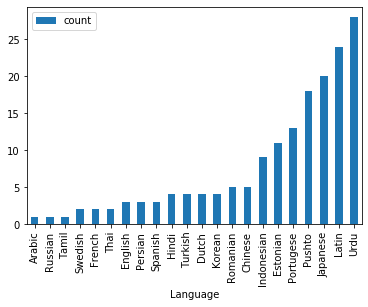

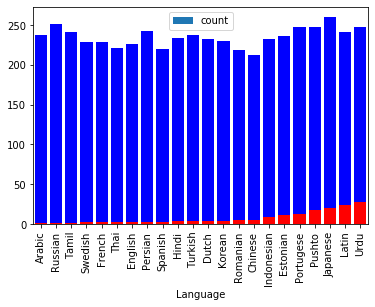

In [3]:
import matplotlib.pyplot as plt
axT = countT.plot.bar(x='Language', y='count', rot=90)
ax = count.plot.bar(x='Language', y='count', rot=90)

plt.bar(countT['Language'], countT['count'], color='r')
plt.bar(countT['Language'],countT['countT'], bottom=countT['count'], color='b')
plt.xticks(rotation=90)
plt.show()



In [9]:
print(classification_report(results2['Language'], results2['LanguageDetected']))

              precision    recall  f1-score   support

      Arabic       0.91      1.00      0.95       236
    Chichewa       0.00      0.00      0.00         0
     Chinese       0.92      0.98      0.95       207
      Danish       0.00      0.00      0.00         0
       Dutch       1.00      0.98      0.99       228
     English       0.75      0.99      0.85       223
    Estonian       1.00      0.95      0.97       225
     Finnish       0.00      0.00      0.00         0
      French       0.97      0.99      0.98       226
      Gaelic       0.00      0.00      0.00         0
    Galician       0.00      0.00      0.00         0
      German       0.00      0.00      0.00         0
    Hawaiian       0.00      0.00      0.00         0
       Hindi       1.00      0.98      0.99       229
  Indonesian       1.00      0.96      0.98       223
     Italian       0.00      0.00      0.00         0
    Japanese       1.00      0.92      0.96       240
      Korean       1.00    

C:\Users\lope25642\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lope25642\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lope25642\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 <a list of 37 Text xticklabel objects>)

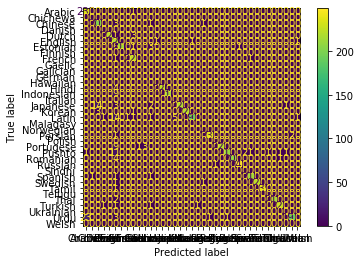

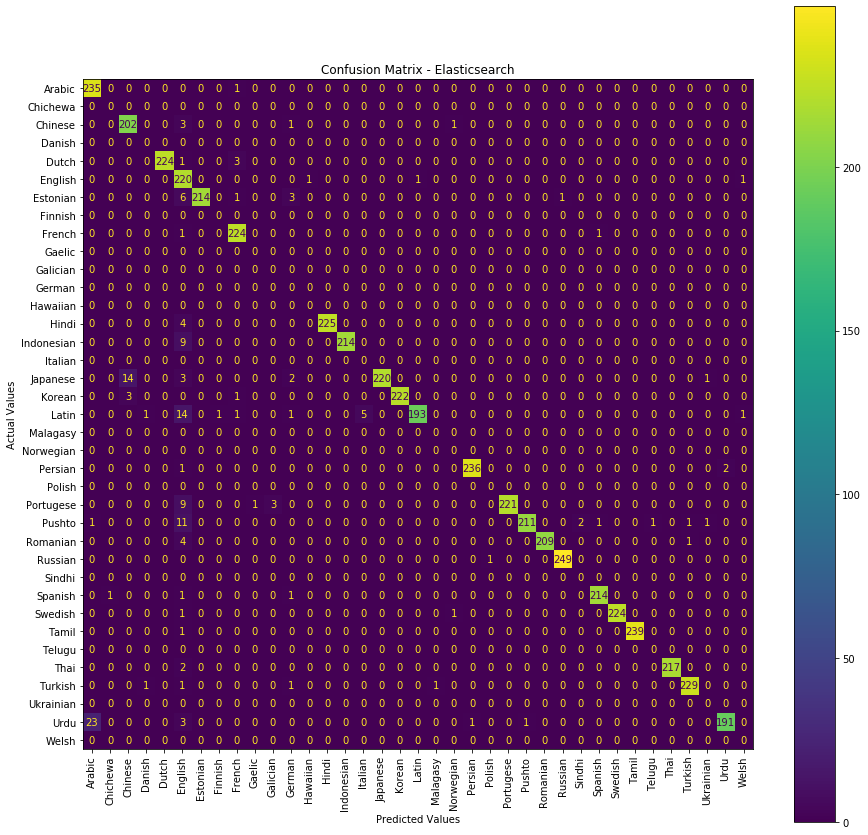

In [15]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
results2  = pd.read_csv('D:\TFM\dataset_multilanguage_result_es-kib.csv')
results2.loc[results2["LanguageDetected"] == "Portuguese", "LanguageDetected"] = "Portugese"
results2.loc[results2["LanguageDetected"] == "Dutch, Flemish", "LanguageDetected"] = "Dutch"
results2.loc[results2["LanguageDetected"] == "Spanish, Castilian", "LanguageDetected"] = "Spanish"
results2.loc[results2["LanguageDetected"] == "Malay", "LanguageDetected"] = "Indonesian"
results2.loc[results2["LanguageDetected"] == "Pashto", "LanguageDetected"] = "Pushto"

cmd = ConfusionMatrixDisplay.from_predictions(results2['Language'], results2['LanguageDetected'])
fig, ax = plt.subplots(figsize=(15,15))
cmd.plot(ax=ax)
cmd.ax_.set(
                title='Confusion Matrix - Elasticsearch', 
                xlabel='Predicted Values', 
                ylabel='Actual Values')

plt.xticks(rotation=90)






In [17]:
from sklearn.metrics import accuracy_score
print(accuracy_score(results2['Language'], results2['LanguageDetected']))

0.9666
